In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from io import StringIO;
import os;
import os.path;
import glob as glob
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [2]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;  

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def validate_column_names_are_consistent(old_column_names,new_column_names):
    if len(old_column_names) != len(new_column_names):
        raise ValueError("!!! Inconsistent number of columns.");
        
    for ci in range(len(old_column_names)):
        if old_column_names[ci] != new_column_names[ci]:
            raise ValueError("!!! Inconsistent column %d) %s != %s" % (ci,old_column_names[ci],new_column_names[ci]));
        pass;
    return;
def get_label_pretty_name(label):
    if 'FIX_walking' in label:
        return 'Walking';
    if 'FIX_running' in label:
        return 'Running';
    if 'LOC_main_workplace' in label:
        return 'At main workplace' ;
    if 'OR_indoors' in label:
        return 'Indoors';
    if 'OR_outside' in label:
        return 'Outside';
    if 'LOC_home' in label:
        return 'At home';
    if 'FIX_restaurant' in label:
        return 'At a restaurant';
    if 'OR_exercise' in label:
        return 'Exercise';
    if  'LOC_beach' in label:
        return 'At the beach';
    if 'OR_standing' in label:
        return 'Standing';
    if 'WATCHING_TV' in label:
        return 'Watching TV'
    else:
        label.replace('label:', '')
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

def get_phone_label(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    
    # if lable is phone related then return the label
    if "Phone" not in label: 
        return label
    else:
        return False


def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;  

def get_features_from_data(users_df):
    for (ci,col) in enumerate(users_df.columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
    pass;
    feature_names = users_df.columns[1:first_label_ind];
    return np.array(feature_names)

def project_features_to_selected_sensors(feature_names,sensors_to_use):

    feature_names_arr = []
    for sensor in sensors_to_use:
        if sensor == 'Acc':
            for feature in feature_names:
                #print (type(feature))
                if (feature.startswith('raw_acc')):
                    feature_names_arr.append(feature)
        elif sensor == 'WAcc':
            for feature in feature_names:
                if (feature.startswith('watch_acceleration')):
                    feature_names_arr.append(feature)
        elif sensor == 'Gyro':
            for feature in feature_names:
                if (feature.startswith('proc_gyro')):
                    feature_names_arr.append(feature)
        elif sensor == 'Magnet':
            for feature in feature_names:
                if (feature.startswith('raw_magnet')):
                    feature_names_arr.append(feature)
        elif sensor == 'Compass':
            for feature in feature_names:
                if (feature.startswith('watch_heading')):
                    feature_names_arr.append(feature)
        elif sensor == 'Loc':
            for feature in feature_names:
                if (feature.startswith('location')):
                    feature_names_arr.append(feature)
        elif sensor == 'Aud':
            for feature in feature_names:
                if (feature.startswith('audio_naive')):
                    feature_names_arr.append(feature)
        elif sensor == 'AP':
            for feature in feature_names:
                if (feature.startswith('audio_properties')):
                    feature_names_arr.append(feature)
        elif sensor == 'PS':
            for feature in feature_names:
                if (feature.startswith('discrete')):
                    feature_names_arr.append(feature)
        elif sensor == 'LF':
            for feature in feature_names:
                if (feature.startswith('lf_measurements')):
                    feature_names_arr.append(feature)
                    
    return feature_names_arr

def estimate_standardization_params(X):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_vec = np.nanmean(X,axis=0);
        std_vec = np.nanstd(X,axis=0);
        return (mean_vec,std_vec);

def standardize_features(X,mean_vec,std_vec):
    # Subtract the mean, to centralize all features around zero:
    X_centralized = X - mean_vec.reshape((1,-1));
    # Divide by the standard deviation, to get unit-variance for all features:
    # * Avoid dividing by zero, in case some feature had estimate of zero variance
    normalizers = np.where(std_vec > 0., std_vec, 1.).reshape((1,-1));
    X_standard = X_centralized / normalizers;
    return X_standard;

def get_label_names(users_df):
    # Search for the column of the first label:
    for (ci,col) in enumerate(users_df.columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    label_names = np.array(users_df.columns[first_label_ind:-1]);
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        #label_names[li] = label.replace('label:','');
        pass;
    
    return (list(label_names));

def print_accuracy_repoprt(predictions, y_test):

    accuracy = np.mean(predictions == y_test);
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(predictions,y_test));
    tn = np.sum(np.logical_and(np.logical_not(predictions),np.logical_not(y_test)));
    fp = np.sum(np.logical_and(predictions,np.logical_not(y_test)));
    fn = np.sum(np.logical_and(np.logical_not(predictions),y_test));

    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    sensitivity = float(tp) / (tp+fn);
    specificity = float(tn) / (tn+fp);

    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;

    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    precision = float(tp) / (tp+fp);
    accuracy_list = [accuracy,sensitivity,specificity,balanced_accuracy,precision]
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    #print('* The accuracy metric is misleading - it is dominated by the negative examples (typically there are many more negatives).')
    #print('** Precision is very sensitive to rare labels. It can cause misleading results when averaging precision over different labels.')
    return accuracy_list

In [3]:
def prepare_X_Y_for_ML(users_df):
    # prepare data for machine learning
    # 1. get all features available
    feature_names = get_features_from_data(users_df)

    feat_sensor_names = get_sensor_names_from_features(feature_names);

    X = users_df[feature_names]

    (mean_vec,std_vec) = estimate_standardization_params(X);
    X = standardize_features(X,mean_vec,std_vec);
    X[np.isnan(X)] = 0.
    # 6. X is ready for training
    # 7. Prepare Y target lables for training
    label_names = get_label_names(users_df)
    Y = users_df[label_names]
    # 8. clean nan values and converted to binary labels
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = users_df[label_names]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    y_df = pd.DataFrame(Y)
    y_df.rename(columns=dict(enumerate(label_names, 0)), inplace = True)
    return (X,y_df,M,feature_names,label_names)

# GET the data
Try reading sample user in order to extract features and label names

In [4]:
df = pd.read_csv("./user1.features_labels.csv")

In [5]:
# process the data to get features data and context label data
(X,Y,M,feature_names,label_names) = prepare_X_Y_for_ML(df)
XY = pd.concat([X, Y], axis=1, sort=False)
XY.head()

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,-0.004166,-0.214889,-0.003052,-0.087991,0.273895,0.086134,-0.157025,-2.102366,0.226534,0.310119,...,False,False,False,False,False,False,False,False,True,False
1,-0.014938,-0.247326,-0.381022,-0.269487,0.277033,0.089902,-0.149119,-0.676587,0.228113,0.228730,...,False,False,False,False,False,False,False,False,True,False
2,0.100089,-0.159482,-0.420238,-0.102435,0.230967,0.223521,-0.082896,-1.156087,0.222563,0.252353,...,False,False,False,False,False,False,False,False,True,False
3,0.177281,-0.176301,-0.024567,-0.105843,0.268802,0.333106,-0.069397,-1.200039,0.223998,0.236435,...,False,False,False,False,False,False,False,False,True,False
4,0.313695,-0.113463,-0.476969,-0.117663,0.270961,0.522589,-0.004443,-0.311339,0.218304,0.222963,...,False,False,False,False,False,False,False,False,True,False


Displaying all columns in the dataset


In [8]:
print("Number of columns in the database =", df.columns.size)
for column in df.columns:
    print (column)

Number of columns in the database = 278
timestamp
raw_acc:magnitude_stats:mean
raw_acc:magnitude_stats:std
raw_acc:magnitude_stats:moment3
raw_acc:magnitude_stats:moment4
raw_acc:magnitude_stats:percentile25
raw_acc:magnitude_stats:percentile50
raw_acc:magnitude_stats:percentile75
raw_acc:magnitude_stats:value_entropy
raw_acc:magnitude_stats:time_entropy
raw_acc:magnitude_spectrum:log_energy_band0
raw_acc:magnitude_spectrum:log_energy_band1
raw_acc:magnitude_spectrum:log_energy_band2
raw_acc:magnitude_spectrum:log_energy_band3
raw_acc:magnitude_spectrum:log_energy_band4
raw_acc:magnitude_spectrum:spectral_entropy
raw_acc:magnitude_autocorrelation:period
raw_acc:magnitude_autocorrelation:normalized_ac
raw_acc:3d:mean_x
raw_acc:3d:mean_y
raw_acc:3d:mean_z
raw_acc:3d:std_x
raw_acc:3d:std_y
raw_acc:3d:std_z
raw_acc:3d:ro_xy
raw_acc:3d:ro_xz
raw_acc:3d:ro_yz
proc_gyro:magnitude_stats:mean
proc_gyro:magnitude_stats:std
proc_gyro:magnitude_stats:moment3
proc_gyro:magnitude_stats:moment4
proc_

Listing feature names available in the dataset.
features columns are all columns except the timestamp and context columns and they are 225 column

In [9]:
print ("Number of features columns in the dataset =",feature_names.size)
print (feature_names)

Number of features columns in the dataset = 225
['raw_acc:magnitude_stats:mean' 'raw_acc:magnitude_stats:std'
 'raw_acc:magnitude_stats:moment3' 'raw_acc:magnitude_stats:moment4'
 'raw_acc:magnitude_stats:percentile25'
 'raw_acc:magnitude_stats:percentile50'
 'raw_acc:magnitude_stats:percentile75'
 'raw_acc:magnitude_stats:value_entropy'
 'raw_acc:magnitude_stats:time_entropy'
 'raw_acc:magnitude_spectrum:log_energy_band0'
 'raw_acc:magnitude_spectrum:log_energy_band1'
 'raw_acc:magnitude_spectrum:log_energy_band2'
 'raw_acc:magnitude_spectrum:log_energy_band3'
 'raw_acc:magnitude_spectrum:log_energy_band4'
 'raw_acc:magnitude_spectrum:spectral_entropy'
 'raw_acc:magnitude_autocorrelation:period'
 'raw_acc:magnitude_autocorrelation:normalized_ac' 'raw_acc:3d:mean_x'
 'raw_acc:3d:mean_y' 'raw_acc:3d:mean_z' 'raw_acc:3d:std_x'
 'raw_acc:3d:std_y' 'raw_acc:3d:std_z' 'raw_acc:3d:ro_xy'
 'raw_acc:3d:ro_xz' 'raw_acc:3d:ro_yz' 'proc_gyro:magnitude_stats:mean'
 'proc_gyro:magnitude_stats:std' 

In [6]:
Y

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2681,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2682,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2683,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
label_names

['label:LYING_DOWN',
 'label:SITTING',
 'label:FIX_walking',
 'label:FIX_running',
 'label:BICYCLING',
 'label:SLEEPING',
 'label:LAB_WORK',
 'label:IN_CLASS',
 'label:IN_A_MEETING',
 'label:LOC_main_workplace',
 'label:OR_indoors',
 'label:OR_outside',
 'label:IN_A_CAR',
 'label:ON_A_BUS',
 'label:DRIVE_-_I_M_THE_DRIVER',
 'label:DRIVE_-_I_M_A_PASSENGER',
 'label:LOC_home',
 'label:FIX_restaurant',
 'label:PHONE_IN_POCKET',
 'label:OR_exercise',
 'label:COOKING',
 'label:SHOPPING',
 'label:STROLLING',
 'label:DRINKING__ALCOHOL_',
 'label:BATHING_-_SHOWER',
 'label:CLEANING',
 'label:DOING_LAUNDRY',
 'label:WASHING_DISHES',
 'label:WATCHING_TV',
 'label:SURFING_THE_INTERNET',
 'label:AT_A_PARTY',
 'label:AT_A_BAR',
 'label:LOC_beach',
 'label:SINGING',
 'label:TALKING',
 'label:COMPUTER_WORK',
 'label:EATING',
 'label:TOILET',
 'label:GROOMING',
 'label:DRESSING',
 'label:AT_THE_GYM',
 'label:STAIRS_-_GOING_UP',
 'label:STAIRS_-_GOING_DOWN',
 'label:ELEVATOR',
 'label:OR_standing',
 'l

In [13]:

X[feature_names].head()

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,lf_measurements:screen_brightness,lf_measurements:temperature_ambient,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24,discrete:time_of_day:between21and3
0,-0.004166,-0.214889,-0.003052,-0.087991,0.273895,0.086134,-0.157025,-2.102366,0.226534,0.310119,...,0.0,0.0,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
1,-0.014938,-0.247326,-0.381022,-0.269487,0.277033,0.089902,-0.149119,-0.676587,0.228113,0.228730,...,0.0,0.0,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
2,0.100089,-0.159482,-0.420238,-0.102435,0.230967,0.223521,-0.082896,-1.156087,0.222563,0.252353,...,0.0,0.0,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
3,0.177281,-0.176301,-0.024567,-0.105843,0.268802,0.333106,-0.069397,-1.200039,0.223998,0.236435,...,0.0,0.0,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
4,0.313695,-0.113463,-0.476969,-0.117663,0.270961,0.522589,-0.004443,-0.311339,0.218304,0.222963,...,0.0,0.0,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848


In [14]:
corr = Y[label_names].corr().sort_values(by=label_names, ascending=False)
corr

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
label:LYING_DOWN,1.000000,-0.722330,-0.155386,-0.011995,NaN,0.878115,NaN,NaN,-0.055173,-0.330135,...,-0.011995,-0.011995,NaN,-0.190658,-0.068248,0.010538,NaN,0.255237,-0.110295,-0.127828
label:SLEEPING,0.878115,-0.631401,-0.138880,-0.010721,NaN,1.000000,NaN,NaN,-0.049312,-0.295066,...,-0.010721,-0.010721,NaN,-0.170405,-0.060999,-0.112601,NaN,0.281964,-0.098579,-0.114249
label:LOC_home,0.578682,-0.467315,-0.246305,-0.020728,NaN,0.503136,NaN,NaN,-0.095343,-0.570495,...,-0.020728,-0.020728,NaN,0.109943,-0.117938,0.031560,NaN,0.365851,-0.190597,-0.220895
label:OR_indoors,0.571356,-0.467428,-0.259254,-0.020994,NaN,0.510663,NaN,NaN,-0.096565,-0.577809,...,-0.020994,-0.020994,NaN,0.135476,-0.119450,0.029015,NaN,0.357030,-0.193041,-0.223727
label:PHONE_ON_TABLE,0.255237,0.044930,-0.461669,-0.035638,NaN,0.281964,NaN,NaN,-0.163926,0.199732,...,-0.035638,-0.035638,NaN,-0.087554,-0.202774,-0.374311,NaN,1.000000,-0.270844,-0.348246
label:PHONE_IN_HAND,0.010538,-0.011279,-0.001931,-0.003913,NaN,-0.112601,NaN,NaN,-0.018000,-0.015380,...,0.095210,-0.003913,NaN,0.006005,-0.022266,1.000000,NaN,-0.374311,-0.035983,-0.041703
label:STAIRS_-_GOING_DOWN,-0.011995,-0.022437,0.077194,-0.000373,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,1.000000,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971
label:STAIRS_-_GOING_UP,-0.011995,-0.022437,0.077194,-0.000373,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,1.000000,-0.000373,NaN,-0.005922,-0.002120,0.095210,NaN,-0.035638,-0.003426,-0.003971
label:OR_exercise,-0.011995,-0.022437,-0.004827,1.000000,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,-0.000373,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971
label:FIX_running,-0.011995,-0.022437,-0.004827,1.000000,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,-0.000373,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971


In [15]:
corr.dropna(how='all')

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
label:LYING_DOWN,1.000000,-0.722330,-0.155386,-0.011995,NaN,0.878115,NaN,NaN,-0.055173,-0.330135,...,-0.011995,-0.011995,NaN,-0.190658,-0.068248,0.010538,NaN,0.255237,-0.110295,-0.127828
label:SLEEPING,0.878115,-0.631401,-0.138880,-0.010721,NaN,1.000000,NaN,NaN,-0.049312,-0.295066,...,-0.010721,-0.010721,NaN,-0.170405,-0.060999,-0.112601,NaN,0.281964,-0.098579,-0.114249
label:LOC_home,0.578682,-0.467315,-0.246305,-0.020728,NaN,0.503136,NaN,NaN,-0.095343,-0.570495,...,-0.020728,-0.020728,NaN,0.109943,-0.117938,0.031560,NaN,0.365851,-0.190597,-0.220895
label:OR_indoors,0.571356,-0.467428,-0.259254,-0.020994,NaN,0.510663,NaN,NaN,-0.096565,-0.577809,...,-0.020994,-0.020994,NaN,0.135476,-0.119450,0.029015,NaN,0.357030,-0.193041,-0.223727
label:PHONE_ON_TABLE,0.255237,0.044930,-0.461669,-0.035638,NaN,0.281964,NaN,NaN,-0.163926,0.199732,...,-0.035638,-0.035638,NaN,-0.087554,-0.202774,-0.374311,NaN,1.000000,-0.270844,-0.348246
label:PHONE_IN_HAND,0.010538,-0.011279,-0.001931,-0.003913,NaN,-0.112601,NaN,NaN,-0.018000,-0.015380,...,0.095210,-0.003913,NaN,0.006005,-0.022266,1.000000,NaN,-0.374311,-0.035983,-0.041703
label:STAIRS_-_GOING_DOWN,-0.011995,-0.022437,0.077194,-0.000373,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,1.000000,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971
label:STAIRS_-_GOING_UP,-0.011995,-0.022437,0.077194,-0.000373,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,1.000000,-0.000373,NaN,-0.005922,-0.002120,0.095210,NaN,-0.035638,-0.003426,-0.003971
label:OR_exercise,-0.011995,-0.022437,-0.004827,1.000000,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,-0.000373,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971
label:FIX_running,-0.011995,-0.022437,-0.004827,1.000000,NaN,-0.010721,NaN,NaN,-0.001714,-0.010254,...,-0.000373,-0.000373,NaN,-0.005922,-0.002120,-0.003913,NaN,-0.035638,-0.003426,-0.003971


In [16]:
corr.dropna(how='all').style.background_gradient(cmap='coolwarm', axis=None)

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,label:OR_indoors,label:OR_outside,label:IN_A_CAR,label:ON_A_BUS,label:DRIVE_-_I_M_THE_DRIVER,label:DRIVE_-_I_M_A_PASSENGER,label:LOC_home,label:FIX_restaurant,label:PHONE_IN_POCKET,label:OR_exercise,label:COOKING,label:SHOPPING,label:STROLLING,label:DRINKING__ALCOHOL_,label:BATHING_-_SHOWER,label:CLEANING,label:DOING_LAUNDRY,label:WASHING_DISHES,label:WATCHING_TV,label:SURFING_THE_INTERNET,label:AT_A_PARTY,label:AT_A_BAR,label:LOC_beach,label:SINGING,label:TALKING,label:COMPUTER_WORK,label:EATING,label:TOILET,label:GROOMING,label:DRESSING,label:AT_THE_GYM,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
label:LYING_DOWN,1.000000,-0.722330,-0.155386,-0.011995,nan,0.878115,nan,nan,-0.055173,-0.330135,0.571356,-0.137891,-0.066056,-0.078336,-0.071416,-0.053833,0.578682,-0.020783,-0.257704,-0.011995,-0.082946,-0.026841,-0.029409,-0.063792,-0.039857,nan,-0.020783,-0.082044,-0.196528,-0.076639,nan,nan,nan,-0.029409,-0.232213,-0.112359,-0.224510,-0.071416,-0.072443,-0.091519,nan,-0.011995,-0.011995,nan,-0.190658,-0.068248,0.010538,nan,0.255237,-0.110295,-0.127828
label:SLEEPING,0.878115,-0.631401,-0.138880,-0.010721,nan,1.000000,nan,nan,-0.049312,-0.295066,0.510663,-0.123243,-0.059039,-0.070015,-0.063830,-0.048115,0.503136,-0.018576,-0.230329,-0.010721,-0.074135,-0.023990,-0.026285,-0.057016,-0.035623,nan,-0.018576,-0.073328,-0.180699,-0.174807,nan,nan,nan,-0.026285,-0.314853,-0.100424,-0.200661,-0.063830,-0.064748,-0.081797,nan,-0.010721,-0.010721,nan,-0.170405,-0.060999,-0.112601,nan,0.281964,-0.098579,-0.114249
label:LOC_home,0.578682,-0.467315,-0.246305,-0.020728,nan,0.503136,nan,nan,-0.095343,-0.570495,0.978348,-0.238285,-0.114150,-0.129352,-0.123412,-0.093028,1.000000,-0.035915,-0.424226,-0.020728,0.107215,-0.046384,-0.050820,0.022084,0.059727,nan,0.031145,0.122946,0.302967,0.066217,nan,nan,nan,0.044070,-0.311100,-0.194164,0.023307,0.008263,0.108559,0.137145,nan,-0.020728,-0.020728,nan,0.109943,-0.117938,0.031560,nan,0.365851,-0.190597,-0.220895
label:OR_indoors,0.571356,-0.467428,-0.259254,-0.020994,nan,0.510663,nan,nan,-0.096565,-0.577809,1.000000,-0.241340,-0.115613,-0.131082,-0.124994,-0.094220,0.978348,-0.036376,-0.408789,-0.020994,0.105625,-0.046978,-0.051472,0.020801,0.058971,nan,0.030751,0.121389,0.299132,0.062283,nan,nan,nan,0.043512,-0.323839,-0.196654,0.018739,0.105665,0.107184,0.135408,nan,-0.020994,-0.020994,nan,0.135476,-0.119450,0.029015,nan,0.357030,-0.193041,-0.223727
label:PHONE_ON_TABLE,0.255237,0.044930,-0.461669,-0.035638,nan,0.281964,nan,nan,-0.163926,0.199732,0.357030,-0.409690,-0.001654,-0.232745,0.007359,-0.056512,0.365851,-0.061750,-0.765668,-0.035638,0.011260,-0.079749,-0.087376,-0.031948,0.034738,nan,0.018114,0.057801,0.158075,-0.043823,nan,nan,nan,0.025632,-0.553267,0.097930,-0.043657,-0.133777,0.032209,0.067427,nan,-0.035638,-0.035638,nan,-0.087554,-0.202774,-0.374311,nan,1.000000,-0.270844,-0.348246
label:PHONE_IN_HAND,0.010538,-0.011279,-0.001931,-0.003913,nan,-0.112601,nan,nan,-0.018000,-0.015380,0.029015,0.000232,-0.021550,-0.025557,-0.023299,-0.017563,0.031560,-0.006780,-0.084074,-0.003913,-0.027061,-0.008757,-0.009594,-0.020812,-0.013003,nan,-0.006780,-0.026766,-0.065958,0.356955,nan,nan,nan,-0.009594,0.045564,-0.036656,-0.073245,0.094735,-0.023634,-0.029857,nan,0.095210,-0.003913,nan,0.006005,-0.022266,1.000000,nan,-0.374311,-0.035983,-0.041703
label:STAIRS_-_GOING_DOWN,-0.011995,-0.022437,0.077194,-0.000373,nan,-0.010721,nan,nan,-0.001714,-0.010254,-0.020994,-0.004283,-0.002052,-0.002433,-0.002218,-0.001672,-0.020728,-0.000646,0.046545,-0.000373,-0.002576,-0.000834,-0.000913,-0.001981,-0.001238,nan,-0.000646,-0.002548,-0.006280,-0.006075,nan,nan,nan,-0.000913,-0.010942,-0.0

In [20]:
#
%%time
corr_all.style.background_gradient(cmap='coolwarm', axis=None)

UsageError: Line magic function `%%time` not found.


In [52]:
n_examples_per_label = np.sum(np.array(Y),axis=0)
labels_and_counts = zip(label_names,n_examples_per_label)
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1])
print ("number of examples for every context label:")
print ("-"*20)
i = 0
label_x_arr = []
label_y_arr = []
for (label,count) in sorted_labels_and_counts:
    i = i +1
    label_x_arr.append(label)
    label_y_arr.append(count)
    print (" %i : %s - %d times"  % (i,label,count))
    pass;

number of examples for every context label:
--------------------
 1 : label:PHONE_ON_TABLE - 2076 times
 2 : label:SITTING - 1543 times
 3 : label:OR_indoors - 1455 times
 4 : label:LOC_home - 1438 times
 5 : label:LYING_DOWN - 748 times
 6 : label:TALKING - 653 times
 7 : label:SLEEPING - 633 times
 8 : label:LOC_main_workplace - 591 times
 9 : label:PHONE_IN_POCKET - 394 times
 10 : label:EATING - 310 times
 11 : label:WATCHING_TV - 257 times
 12 : label:SURFING_THE_INTERNET - 242 times
 13 : label:OR_standing - 231 times
 14 : label:FIX_walking - 158 times
 15 : label:OR_outside - 126 times
 16 : label:WITH_FRIENDS - 109 times
 17 : label:PHONE_IN_HAND - 106 times
 18 : label:COMPUTER_WORK - 85 times
 19 : label:WITH_CO-WORKERS - 82 times
 20 : label:DRESSING - 57 times
 21 : label:COOKING - 47 times
 22 : label:WASHING_DISHES - 46 times
 23 : label:ON_A_BUS - 42 times
 24 : label:GROOMING - 36 times
 25 : label:DRIVE_-_I_M_THE_DRIVER - 35 times
 26 : label:TOILET - 35 times
 27 : l

<AxesSubplot:xlabel='label'>

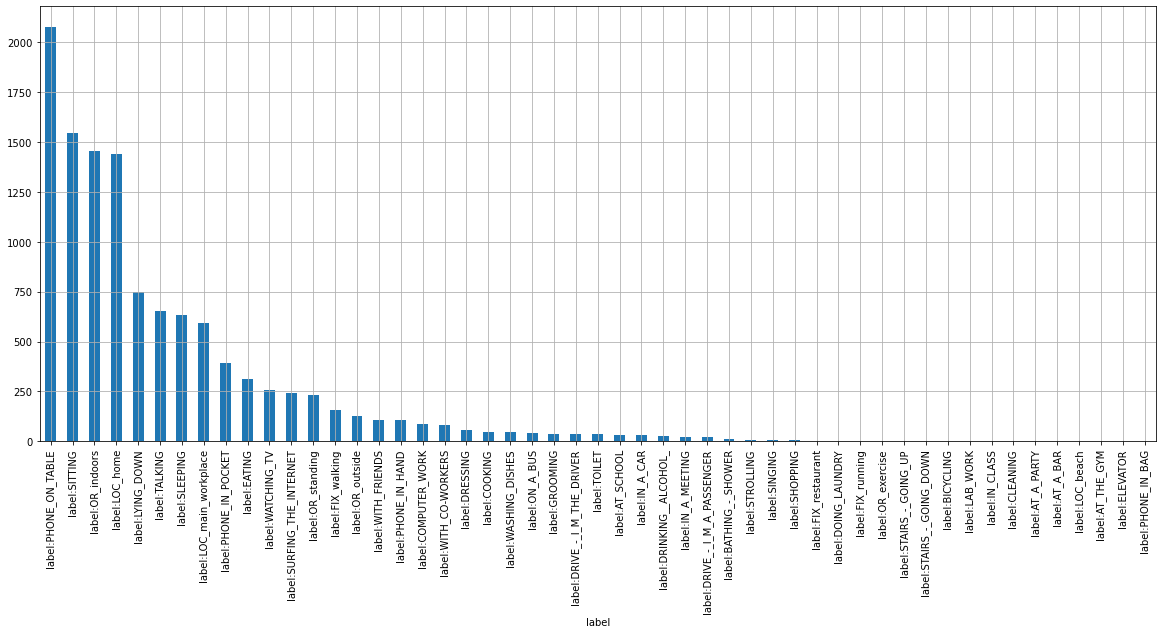

In [19]:
#X.isnull().values.any()
labels_df = pd.DataFrame(sorted_labels_and_counts)
labels_df.rename(columns = {0:'label'}, inplace = True) 
labels_df.rename(columns = {1:'count'}, inplace = True) 
labels_df.plot(x='label', y='count', kind='bar', legend=False, grid=True, figsize=(20, 8))

In [20]:
feat_sensor_names = get_sensor_names_from_features(feature_names)
print(pd.unique(feat_sensor_names))

['Acc' 'Gyro' 'Magnet' 'WAcc' 'Compass' 'Loc' 'Aud' 'AP' 'PS' 'LF']


In [56]:
features_of_selected_sensors =  project_features_to_selected_sensors(feature_names,['Acc', 'WAcc','Gyro','Loc','Aud','PS'])
features_of_selected_sensors

['raw_acc:magnitude_stats:mean',
 'raw_acc:magnitude_stats:std',
 'raw_acc:magnitude_stats:moment3',
 'raw_acc:magnitude_stats:moment4',
 'raw_acc:magnitude_stats:percentile25',
 'raw_acc:magnitude_stats:percentile50',
 'raw_acc:magnitude_stats:percentile75',
 'raw_acc:magnitude_stats:value_entropy',
 'raw_acc:magnitude_stats:time_entropy',
 'raw_acc:magnitude_spectrum:log_energy_band0',
 'raw_acc:magnitude_spectrum:log_energy_band1',
 'raw_acc:magnitude_spectrum:log_energy_band2',
 'raw_acc:magnitude_spectrum:log_energy_band3',
 'raw_acc:magnitude_spectrum:log_energy_band4',
 'raw_acc:magnitude_spectrum:spectral_entropy',
 'raw_acc:magnitude_autocorrelation:period',
 'raw_acc:magnitude_autocorrelation:normalized_ac',
 'raw_acc:3d:mean_x',
 'raw_acc:3d:mean_y',
 'raw_acc:3d:mean_z',
 'raw_acc:3d:std_x',
 'raw_acc:3d:std_y',
 'raw_acc:3d:std_z',
 'raw_acc:3d:ro_xy',
 'raw_acc:3d:ro_xz',
 'raw_acc:3d:ro_yz',
 'watch_acceleration:magnitude_stats:mean',
 'watch_acceleration:magnitude_stats

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X[features_of_selected_sensors], Y['label:FIX_walking'], test_size=0.30, random_state=42)

In [58]:
%time
logmodel = LogisticRegression(max_iter=200)
logmodel.fit(X_train,y_train)

Wall time: 0 ns


LogisticRegression(max_iter=200)

In [59]:
%time
predictions = logmodel.predict(X_test)

Wall time: 0 ns


In [61]:
logmodel_results =  print_accuracy_repoprt(predictions,y_test)

----------
Accuracy*:         0.96
Sensitivity (TPR): 0.77
Specificity (TNR): 0.97
Balanced accuracy: 0.87
Precision**:       0.59
----------


In [62]:
lm = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X[features_of_selected_sensors], Y["label:FIX_walking"], test_size=0.20, shuffle=True, random_state=42)    
lm.fit(X_train,y_train)

LinearRegression()

In [63]:
# calculate these metrics by hand!
predictions = lm.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.07678296488557716
MSE: 0.020625508032708934
RMSE: 0.14361583489542137


In [64]:
lm_results =  print_accuracy_repoprt(predictions,y_test)

----------
Accuracy*:         0.00
Sensitivity (TPR): 1.00
Specificity (TNR): 0.00
Balanced accuracy: 0.50
Precision**:       0.05
----------


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [66]:
scaler.fit(XY[features_of_selected_sensors])

StandardScaler()

In [67]:
%%time
scaled_features = scaler.transform(XY[features_of_selected_sensors])

Wall time: 14 ms


In [68]:
%%time
df_feat = pd.DataFrame(scaled_features,columns=features_of_selected_sensors)
df_feat.head()

Wall time: 998 µs


,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,discrete:wifi_status:is_reachable_via_wwan,discrete:wifi_status:missing,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24,discrete:time_of_day:between21and3
0,-0.004166,-0.214889,-0.003052,-0.087991,0.273895,0.086134,-0.157025,-2.102366,0.226534,0.310119,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
1,-0.014938,-0.247326,-0.381022,-0.269487,0.277033,0.089902,-0.149119,-0.676587,0.228113,0.228730,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
2,0.100089,-0.159482,-0.420238,-0.102435,0.230967,0.223521,-0.082896,-1.156087,0.222563,0.252353,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
3,0.177281,-0.176301,-0.024567,-0.105843,0.268802,0.333106,-0.069397,-1.200039,0.223998,0.236435,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
4,0.313695,-0.113463,-0.476969,-0.117663,0.270961,0.522589,-0.004443,-0.311339,0.218304,0.222963,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848


In [69]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,XY['label:FIX_walking'],test_size=0.30, random_state=42)

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
knn = KNeighborsClassifier(n_neighbors=1)

In [72]:
%%time
knn.fit(X_train,y_train)

Wall time: 1.99 ms


KNeighborsClassifier(n_neighbors=1)

In [73]:
%%time
pred = knn.predict(X_test)

Wall time: 86.7 ms


In [74]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
knn_results =  print_accuracy_repoprt(pred,y_test)

[[752  15]
 [ 13  26]]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       767
        True       0.63      0.67      0.65        39

    accuracy                           0.97       806
   macro avg       0.81      0.82      0.82       806
weighted avg       0.97      0.97      0.97       806

----------
Accuracy*:         0.97
Sensitivity (TPR): 0.67
Specificity (TNR): 0.98
Balanced accuracy: 0.82
Precision**:       0.63
----------


# Choosing a K Value


In [75]:
%%time
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Wall time: 3.26 s


Text(0, 0.5, 'Error Rate')

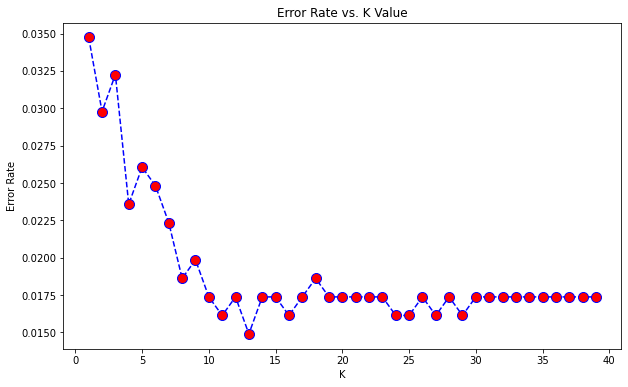

In [76]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [79]:
%%time
# NOW WITH K=30
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))
knn_results =  print_accuracy_repoprt(pred,y_test)

[[763   4]
 [  8  31]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       767
        True       0.89      0.79      0.84        39

    accuracy                           0.99       806
   macro avg       0.94      0.89      0.92       806
weighted avg       0.98      0.99      0.98       806

----------
Accuracy*:         0.99
Sensitivity (TPR): 0.79
Specificity (TNR): 0.99
Balanced accuracy: 0.89
Precision**:       0.89
----------
Wall time: 106 ms


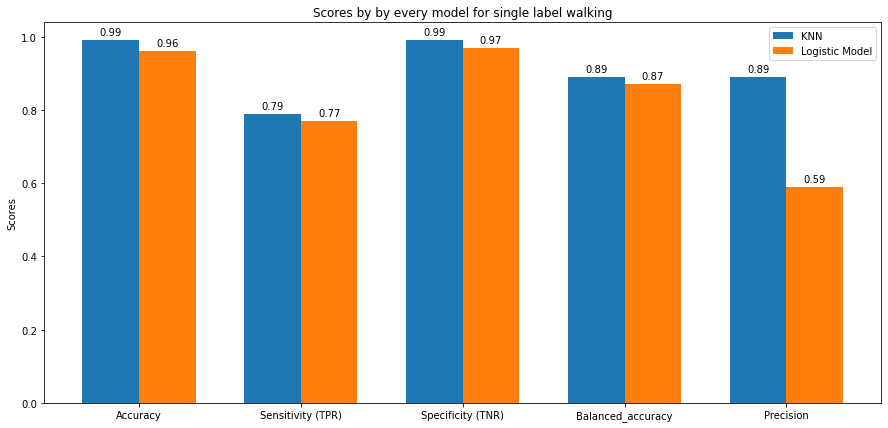

In [80]:
single_label_models_results = [logmodel_results, lm_results, knn_results]
data = single_label_models_results
x_axis = np.arange(5)


accuracy_list = ['Accuracy', 'Sensitivity (TPR)', 'Specificity (TNR)', 'Balanced_accuracy', 'Precision']

width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(x_axis - width/2 , np.round(knn_results, decimals=2) , width, label='KNN')
#rects2 = ax.bar(x_axis + 00.25, np.round(lm_results, decimals=2) , width, label='Linear')
rects2 = ax.bar(x_axis + width/2, np.round(logmodel_results, decimals=2) , width, label='Logistic Model')

ax.set_xticks(x_axis)
ax.set_ylabel('Scores')
ax.set_title('Scores by by every model for single label walking')
ax.set_xticklabels(accuracy_list)
ax.legend()

def autolabel(rects):
 
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# KNN show much more better results over logistic regression model
# Multiple Label Classification

iterating through multiple label at one time
selection of the below labels

label:LYING_DOWN

label:LOC_home

label:LOC_main_workplace

label:SITTING

label:OR_standing

label:FIX_walking

label:SLEEPING


In [81]:
arr_labels = ['label:FIX_walking','label:LYING_DOWN','label:LOC_home','label:LOC_main_workplace','label:SITTING','label:OR_standing', 'label:SLEEPING']
mlp_logmodel_results = list()
for label in arr_labels:
    X_train, X_test, y_train, y_test = train_test_split(X[features_of_selected_sensors], Y[label], test_size=0.30, random_state=42)    
    logmodel = LogisticRegression(max_iter=200)
    logmodel.fit(X_train,y_train)
    predictions = logmodel.predict(X_test)
    print ("********************** "+label+" ******************")
    print(classification_report(y_test,predictions))
    mlp_logmodel_results.append(print_accuracy_repoprt(predictions,y_test))

********************** label:FIX_walking ******************
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       767
        True       0.59      0.77      0.67        39

    accuracy                           0.96       806
   macro avg       0.79      0.87      0.82       806
weighted avg       0.97      0.96      0.97       806

----------
Accuracy*:         0.96
Sensitivity (TPR): 0.77
Specificity (TNR): 0.97
Balanced accuracy: 0.87
Precision**:       0.59
----------
********************** label:LYING_DOWN ******************
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       572
        True       0.95      0.91      0.93       234

    accuracy                           0.96       806
   macro avg       0.96      0.95      0.95       806
weighted avg       0.96      0.96      0.96       806

----------
Accuracy*:         0.96
Sensitivity (TPR): 0.91
Specificity (TNR): 0.98
Ba

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X[features_of_selected_sensors], Y, test_size=0.30, random_state=42)    

In [83]:

LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])
for label in arr_labels:
    print('**Processing {} context label...**'.format(label))
    
    LogReg_pipeline.fit(X_train, y_train[label])
    

    predictions = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[label], predictions)))
    print("\n")

**Processing label:FIX_walking context label...**
Test accuracy is 0.9689826302729528


**Processing label:LYING_DOWN context label...**
Test accuracy is 0.9627791563275434


**Processing label:LOC_home context label...**
Test accuracy is 0.9851116625310173


**Processing label:LOC_main_workplace context label...**
Test accuracy is 0.9516129032258065


**Processing label:SITTING context label...**
Test accuracy is 0.890818858560794


**Processing label:OR_standing context label...**
Test accuracy is 0.9330024813895782


**Processing label:SLEEPING context label...**
Test accuracy is 0.9714640198511166




In [84]:
scaler = StandardScaler()
scaler.fit(XY[features_of_selected_sensors])
scaled_features = scaler.transform(XY[features_of_selected_sensors])
df_feat = pd.DataFrame(scaled_features,columns=features_of_selected_sensors)
df_feat.head()

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,discrete:wifi_status:is_reachable_via_wwan,discrete:wifi_status:missing,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24,discrete:time_of_day:between21and3
0,-0.004166,-0.214889,-0.003052,-0.087991,0.273895,0.086134,-0.157025,-2.102366,0.226534,0.310119,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
1,-0.014938,-0.247326,-0.381022,-0.269487,0.277033,0.089902,-0.149119,-0.676587,0.228113,0.228730,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
2,0.100089,-0.159482,-0.420238,-0.102435,0.230967,0.223521,-0.082896,-1.156087,0.222563,0.252353,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
3,0.177281,-0.176301,-0.024567,-0.105843,0.268802,0.333106,-0.069397,-1.200039,0.223998,0.236435,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848
4,0.313695,-0.113463,-0.476969,-0.117663,0.270961,0.522589,-0.004443,-0.311339,0.218304,0.222963,...,0.0,-0.043193,-0.471887,-0.390967,-0.49359,-0.593265,1.479472,1.42016,-0.667743,-0.657848


In [85]:

mlp_knn_results = list()
for label in arr_labels:
    X_train, X_test, y_train, y_test = train_test_split(scaled_features,XY[label],test_size=0.30, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=17)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    print ("********************** "+label+" ******************")
    print('Test accuracy is {}'.format(accuracy_score(pred,y_test)))
    mlp_knn_results.append(print_accuracy_repoprt(pred,y_test))
    print("\n")

********************** label:FIX_walking ******************
Test accuracy is 0.9826302729528535
----------
Accuracy*:         0.98
Sensitivity (TPR): 0.77
Specificity (TNR): 0.99
Balanced accuracy: 0.88
Precision**:       0.86
----------


********************** label:LYING_DOWN ******************
Test accuracy is 0.9553349875930521
----------
Accuracy*:         0.96
Sensitivity (TPR): 0.87
Specificity (TNR): 0.99
Balanced accuracy: 0.93
Precision**:       0.97
----------


********************** label:LOC_home ******************
Test accuracy is 0.9602977667493796
----------
Accuracy*:         0.96
Sensitivity (TPR): 0.98
Specificity (TNR): 0.94
Balanced accuracy: 0.96
Precision**:       0.95
----------


********************** label:LOC_main_workplace ******************
Test accuracy is 0.9416873449131513
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.90
Specificity (TNR): 0.95
Balanced accuracy: 0.93
Precision**:       0.85
----------


********************** label:SITTING 

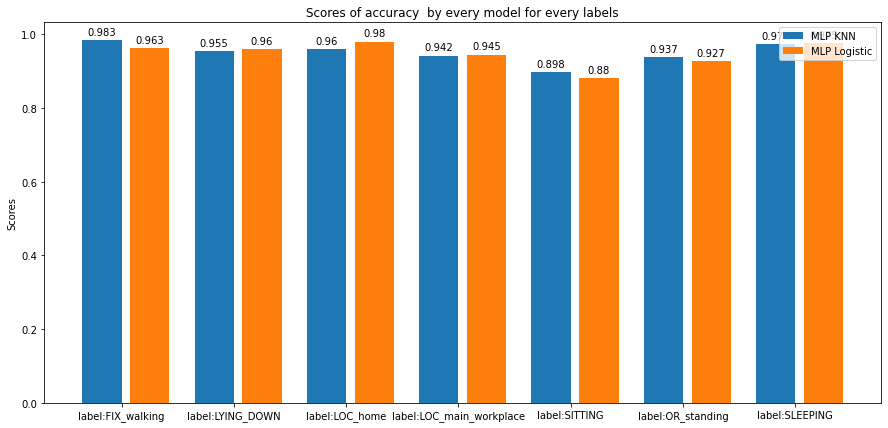

In [86]:

x_axis = np.arange(7)



width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(x_axis - width/2 , np.round(np.array(mlp_knn_results)[:,0], decimals=3) , width, label='MLP KNN')
rects2 = ax.bar(x_axis + 00.25, np.round(np.array(mlp_logmodel_results)[:,0], decimals=3) , width, label='MLP Logistic')

ax.set_xticks(x_axis)
ax.set_ylabel('Scores')
ax.set_title('Scores of accuracy  by every model for every labels')
ax.set_xticklabels(arr_labels)
ax.legend()

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

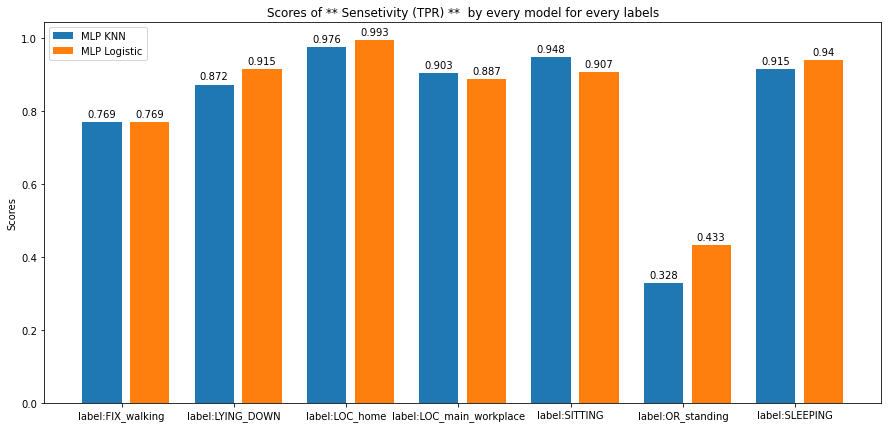

In [87]:

x_axis = np.arange(7)



width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(x_axis - width/2 , np.round(np.array(mlp_knn_results)[:,1], decimals=3) , width, label='MLP KNN')
rects2 = ax.bar(x_axis + 00.25, np.round(np.array(mlp_logmodel_results)[:,1], decimals=3) , width, label='MLP Logistic')

ax.set_xticks(x_axis)
ax.set_ylabel('Scores')
ax.set_title('Scores of ** Sensetivity (TPR) **  by every model for every labels')
ax.set_xticklabels(arr_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

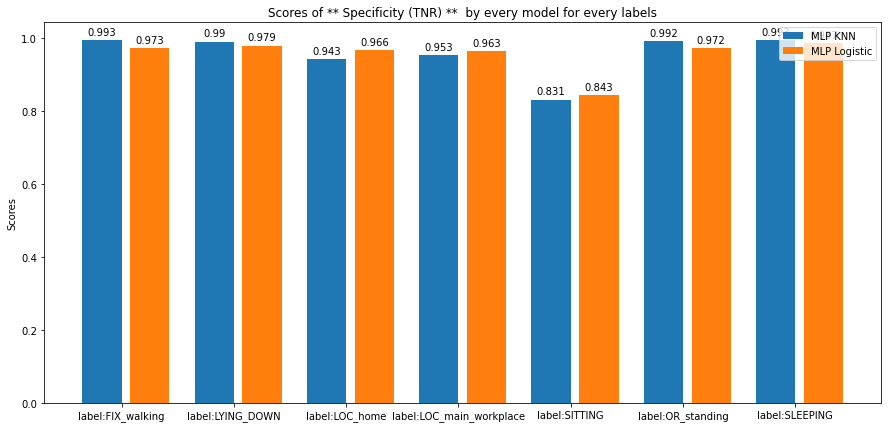

In [88]:

x_axis = np.arange(7)


#arr_labels = ['LYING_DOWN','LOC_home','LOC_main_workplace','SITTING','OR_standing','FIX_walking', 'SLEEPING']

width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(x_axis - width/2 , np.round(np.array(mlp_knn_results)[:,2], decimals=3) , width, label='MLP KNN')
rects2 = ax.bar(x_axis + 00.25, np.round(np.array(mlp_logmodel_results)[:,2], decimals=3) , width, label='MLP Logistic')
#rects2 = ax.bar(x_axis + width/2, np.round(logmodel_results, decimals=2) , width, label='Logistic Model')

ax.set_xticks(x_axis)
ax.set_ylabel('Scores')
ax.set_title('Scores of ** Specificity (TNR) **  by every model for every labels')
ax.set_xticklabels(arr_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

In [51]:
np.array(mlp_knn_results)[:,0]

array([0.98511166, 0.8573201 , 0.78784119, 0.82506203, 0.79280397,
       0.9292804 , 0.87468983])